In [6]:
import json
from glob import glob
from os.path import join as pjoin
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

from match_elements.GUI_pair import GUIPair
from GUI import GUI
from Operation import Operation

In [2]:
# load resnet for encoding image to match
from keras.applications.resnet import ResNet50
resnet_model = ResNet50(include_top=False, input_shape=(32, 32, 3))

In [3]:
# load PaddleOCR for text detection
from paddleocr import PaddleOCR
paddle_ocr = PaddleOCR(use_angle_cls=True, lang='en')

[2022/03/02 12:09:39] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2022/03/02 12:09:39] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2022/03/02 12:09:39] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/ml/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/ml/.paddleocr/2.3.0.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_s

In [4]:
# load operations
testing_data_root = '/home/ml/Data/visual testing/experiments/humanoid-output/adguard-1'

steps_file = pjoin(testing_data_root, 'output.json')
steps = json.load(open(steps_file, 'r'))

operations = []
for step in steps:
    op = Operation(pjoin(testing_data_root, step['tag'] + '.jpg'), step['event_type'], step['bounds'])
    op.shrink_target_element_img()
    op.resize(int(op.ui_img_width * (800 / op.ui_img_height)), 800)        
    op.detect_text(paddle_ocr)
    operations.append(op)
#     op.show_target_ele()
    break

# test with the first operation
opr = operations[0]
opr.show_target_ele()

[2022/03/02 12:09:39] root DEBUG: dt_boxes num : 0, elapse : 0.03370547294616699
[2022/03/02 12:09:39] root DEBUG: cls num  : 0, elapse : 0
[2022/03/02 12:09:39] root DEBUG: rec_res num  : 0, elapse : 2.1457672119140625e-06
[Text Detection Completed in 0.036 s] Input: data/operation/target.png Output: data/operation/target.json


In [5]:
# activate the robot
from robot.robot_control import RobotController
robot = RobotController(speed=10000)
robot.reset()

robot_y2img_x = round(130/540, 2)  # y_robot : x_img = 130: 540
robot_x2img_y = round((310-120)/820, 2)  # x_robot : y_img = 310: 820

def cvt_image_pos_to_robot_coord(x_img, y_img):
    x_robot = int((820 - y_img) * robot_x2img_y) + 120
    y_robot = int((270 - x_img) * robot_y2img_x)
    return x_robot, y_robot

[D 220302 12:09:42 robot_control:21] Loading Robot Drivers...


In [6]:
robot.reset()

[D 220302 12:09:56 robot_control:21] Loading Robot Drivers...


In [7]:
# ********************************************
# *** Streaming Detection with Key Control ***
# ********************************************
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

while(1):
    ret, frame = cap.read()
    frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    frame = frame[80:900, :]
    
    cv2.imshow('camera', frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    elif key == ord('s'):
        cv2.imwrite('data/output/temp.jpg', frame)
        
        # 1. detect GUI element in the frame         
        gui = GUI('data/output/temp.jpg')
        gui.detect_element(True, True, True, paddle_cor=paddle_ocr)
        cv2.imshow('result', gui.det_result_imgs['merge'])
        
        # 2. focus on the screen region and adjust all elements
        gui.adjust_elements_by_screen()
        matched_ele = gui.match_elements(target_ele_img=opr.target_element_img, target_ele_text=opr.get_text_content(), resnet_model=resnet_model)
        board = gui.img.copy()
        matched_ele.draw_element(board, show=False)
        # cv2.imshow('matching result', board)
        plt.imshow(board)
        plt.show()
        
        # 3. operate by the robot
        print('The position of matched element:(%d, %d)' % (matched_ele.center_x, matched_ele.center_y))
        x_robot, y_robot = cvt_image_pos_to_robot_coord(matched_ele.center_x, matched_ele.center_y)
        robot.click((x_robot, y_robot, 20))
        
        print('===================\n')
cap.release()
cv2.destroyAllWindows()

[2022/03/02 12:10:04] root DEBUG: dt_boxes num : 20, elapse : 0.15513110160827637
[2022/03/02 12:10:05] root DEBUG: cls num  : 20, elapse : 0.07093262672424316
[2022/03/02 12:10:05] root DEBUG: rec_res num  : 20, elapse : 0.1176462173461914
[Text Detection Completed in 0.361 s] Input: data/output/temp.jpg Output: data/output/ocr/temp.json
[Compo Detection Completed in 0.422 s] Input: data/output/temp.jpg Output: data/output/ip/temp.json
[Merge Completed] Input: data/output/temp.jpg Output: data/output/merge/temp.jpg
Match by image
The position of matched element:(151, 91)


[D 220302 12:10:11 robot_control:36] Robot Click X: 287, Y:28
[D 220302 12:10:11 robot_control:21] Loading Robot Drivers...


In [3]:
from matplotlib import pyplot as plt
import cv2

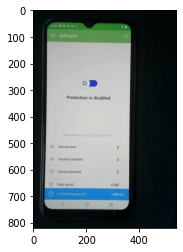

In [4]:
img = cv2.imread('data/input/temp.jpg')
plt.imshow(img)
plt.show()